# CESM2-LE Initial Condition Memory:  Butterworth Filter

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2022.12.1'

## Retrieve PI-Control MOC Time Series

In [3]:
%%time
pidir = '/glade/work/yeager/cesm_output/CESM2_picntrl/'
f0 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.0001-2000.MOCsig.nc'
ds0 = xr.open_dataset(f0)
#ds0 = xr.open_dataset(f0),chunks={'time':120}).persist()
#daskresult = wait(ds0)

CPU times: user 22.9 ms, sys: 8.58 ms, total: 31.4 ms
Wall time: 379 ms


In [4]:
pi_amoc45 = ds0.MOC.sum('moc_comp').isel(transport_reg=1).sel(lat_aux_grid=45.,method='nearest').max('sigma')
pi_amoc45

<xarray.DataArray 'MOC' (time: 2000)>
array([21.852526, 21.383104, 21.421087, ..., 22.138618, 22.672764,
       21.594248], dtype=float32)
Coordinates:
    lat_aux_grid   float64 44.76
    transport_reg  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador Sea ...
  * time           (time) int64 1 2 3 4 5 6 7 ... 1995 1996 1997 1998 1999 2000

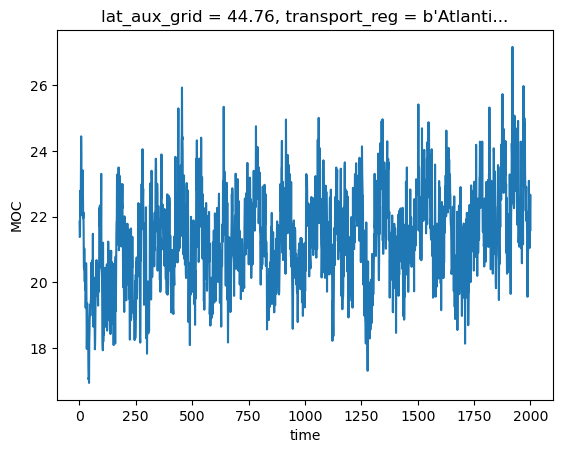

In [5]:
pi_amoc45.plot()

## Butterworth Low-Pass Filter

In [68]:
def lpf_anndata(dat, period=10, order=4):
    fs=1                      # 1/year
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = 1/period        # cutoff frequency
    print('cutoff= ',period,' years') 
    filtsos = signal.butter(order, cutoff, 'lowpass', output='sos', fs=fs) #low pass filter
    b, a = signal.butter(order, cutoff, 'lowpass', output='ba', fs=fs) #low pass filter
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, 
                             filtsos,dat.fillna(0),
                             dask='allowed',
                             kwargs={'padtype':'even','axis':0}).where(dat.notnull()).astype('float32')
    return dat_out,filtsos,a,b

### Order=4

In [69]:
%%time
moc_lpf5,sos5,a5,b5 = lpf_anndata(pi_amoc45,period=5,order=4)
moc_lpf15,sos15,a15,b15 = lpf_anndata(pi_amoc45,period=15,order=4)

cutoff=  5  years
cutoff=  15  years
CPU times: user 8.77 ms, sys: 0 ns, total: 8.77 ms
Wall time: 8.78 ms


Text(0.5, 1.0, 'CESM2 PI Control, Annual AMOC@45N')

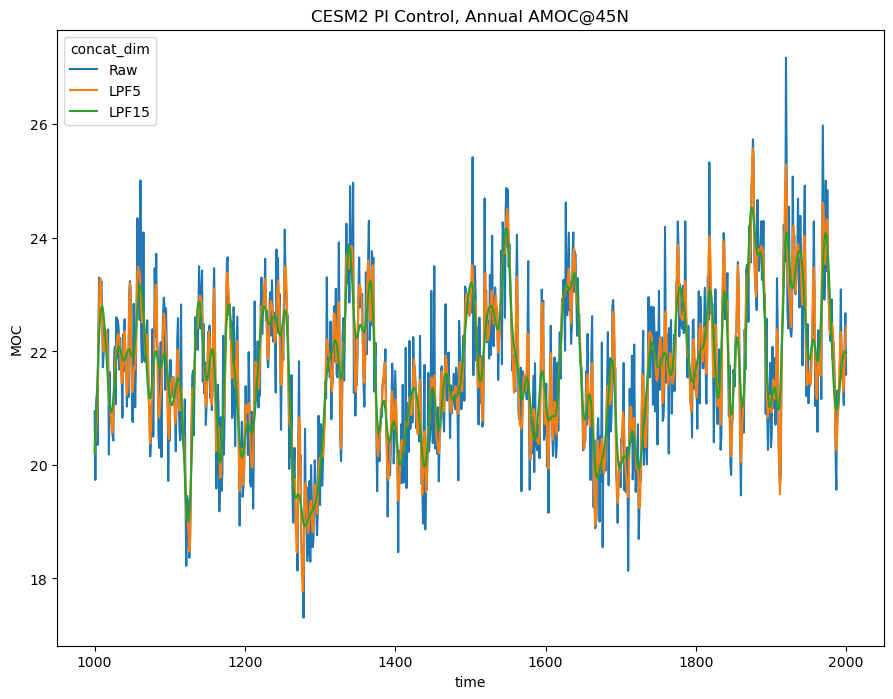

In [70]:
tmp = xr.concat([pi_amoc45,moc_lpf5,moc_lpf15],dim=['Raw','LPF5','LPF15'])
tmp.sel(time=slice(1000,2000)).plot.line(x='time',size=8)
plt.title("CESM2 PI Control, Annual AMOC@45N")

In [71]:
def compute_frequency_response(a, b, fs):
    w_vals, h_vals = signal.freqz(b,a,fs=fs)
    f_db = w_vals 
    db = 20 * np.log10(abs(h_vals))
    return f_db, db 

In [92]:
fs=1  
f5,h5 = compute_frequency_response(a5,b5,fs)
f15,h15 = compute_frequency_response(a15,b15,fs)

/glade/scratch/yeager/tmp/ipykernel_30211/984668206.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


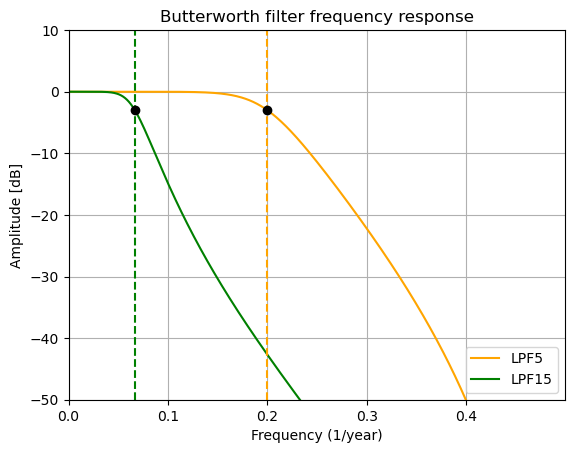

In [100]:
plt.plot(f5, h5, label='LPF5',color='orange')
plt.plot(f15, h15, label='LPF15',color='green')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency (1/year)')
plt.ylabel('Amplitude [dB]')
ax = plt.axes()
ax.set_ylim(-50, 10)
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
cutoff = 1/5
plt.axvline(cutoff, color='orange',ls='--') # cutoff frequency
plt.plot(cutoff, -3, 'ko')
cutoff = 1/15
plt.axvline(cutoff, color='green',ls='--') # cutoff frequency
plt.plot(cutoff, -3, 'ko')
ax.legend(loc='lower right')
plt.show()

Dashed vertical lines show cutoff frequency for 5-year and 15-year lowpass filters. Black dot shows -3dB gain (which occurs at cutoff frequency).

### Order=12

In [101]:
%%time
moc_lpf5,sos5,a5,b5 = lpf_anndata(pi_amoc45,period=5,order=12)
moc_lpf15,sos15,a15,b15 = lpf_anndata(pi_amoc45,period=15,order=12)

cutoff=  5  years
cutoff=  15  years
CPU times: user 8.95 ms, sys: 973 µs, total: 9.93 ms
Wall time: 9.93 ms


Text(0.5, 1.0, 'CESM2 PI Control, Annual AMOC@45N')

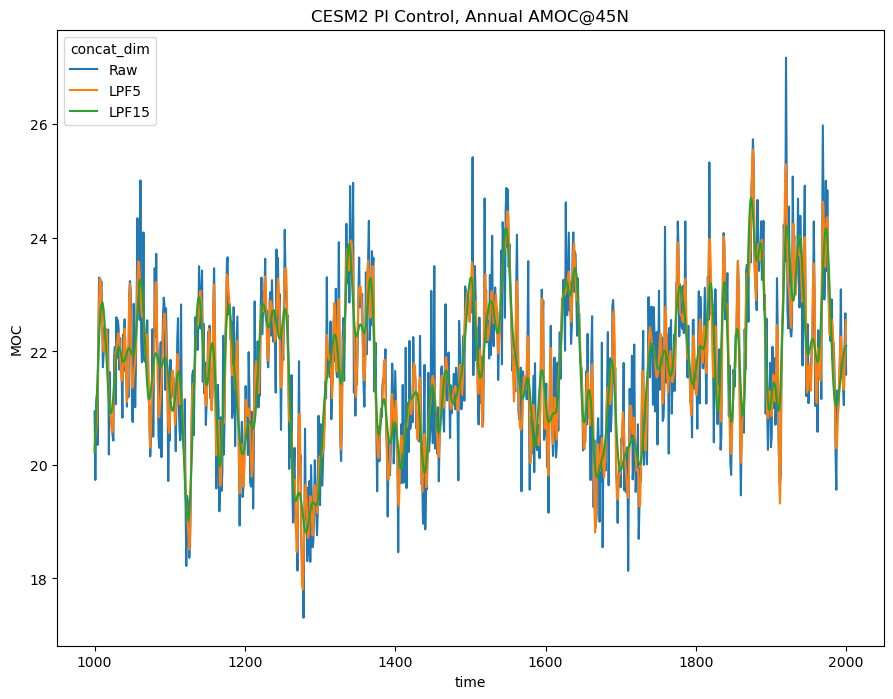

In [102]:
tmp = xr.concat([pi_amoc45,moc_lpf5,moc_lpf15],dim=['Raw','LPF5','LPF15'])
tmp.sel(time=slice(1000,2000)).plot.line(x='time',size=8)
plt.title("CESM2 PI Control, Annual AMOC@45N")

In [103]:
fs=1  
f5,h5 = compute_frequency_response(a5,b5,fs)
f15,h15 = compute_frequency_response(a15,b15,fs)

/glade/scratch/yeager/tmp/ipykernel_30211/984668206.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


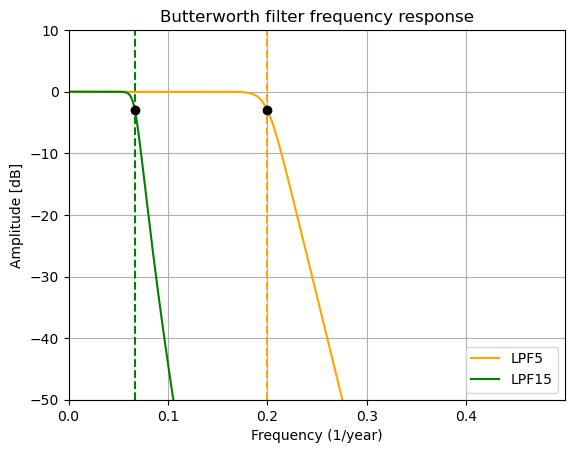

In [104]:
plt.plot(f5, h5, label='LPF5',color='orange')
plt.plot(f15, h15, label='LPF15',color='green')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency (1/year)')
plt.ylabel('Amplitude [dB]')
ax = plt.axes()
ax.set_ylim(-50, 10)
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
cutoff = 1/5
plt.axvline(cutoff, color='orange',ls='--') # cutoff frequency
plt.plot(cutoff, -3, 'ko')
cutoff = 1/15
plt.axvline(cutoff, color='green',ls='--') # cutoff frequency
plt.plot(cutoff, -3, 'ko')
ax.legend(loc='lower right')
plt.show()